In [128]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import combinations,product
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import GridSearchCV
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.circuit import ParameterVector
from cuquantum import *
import time

In [129]:
## First, get 1k MNIST data of only 2-type each. And  

mnist = fetch_openml('mnist_784')
X = mnist.data.to_numpy()
Y = mnist.target.to_numpy().astype(int)
class_list = [7,9]
c01 = np.where((Y == class_list[0])|(Y == class_list[1]))
X,Y = X[c01],Y[c01]
MAX=500
data_train, label_train = X[:MAX],Y[:MAX]
X_train, X_val, Y_train, Y_val = train_test_split(data_train, label_train, test_size = 0.2, random_state=255)

In [130]:
print('train & val shape:',X_train.shape, X_val.shape)
print('train class count:',len(Y_train[np.where(Y_train==class_list[0])]),len(Y_train[np.where(Y_train==class_list[1])]))
print('test  class count:',len(Y_val[np.where(Y_val==class_list[0])]),len(Y_val[np.where(Y_val==class_list[1])]))

train & val shape: (400, 784) (100, 784)
train class count: 211 189
test  class count: 52 48


In [131]:
nb1,nb2=100,50
def data_prepare(n_dim, sample_train, sample_test):
    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    pca = PCA(n_components=n_dim, svd_solver="auto").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)[:nb1]
    sample_test = minmax_scale.transform(sample_test)[:nb2]
    return sample_train, sample_test
def svm_score(sample_train,labels_train,sample_val,labels_val):
    parameters = {'C':[1], 'gamma': [0.001, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 50, 100, 1000]}
    svc_grid_search = SVC(kernel="rbf")
    clf = GridSearchCV(svc_grid_search, param_grid=parameters, scoring='accuracy')
    clf.fit(sample_train,labels_train)
    result1=clf.score(sample_train,labels_train)
    result2=clf.score(sample_val,labels_val)
    return result1, result2

In [132]:
for q in [10]:
    n_dim = q
    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
    score1, score2 = svm_score(data_train,Y_train[:nb1],data_val,Y_val[:nb2])
    print(n_dim,score1, score2)
#for q in [200,300,400,500,600,784]:
#    n_dim = q
#    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
#    score1, score2 = svm_score(data_train,Y_train[:100],data_val,Y_val[:50])
#    print(n_dim,score1, score2)

10 0.97 0.98


---

## statevector simulation

In [125]:
def make_bsp(n_dim):
    param = ParameterVector("p",n_dim)
    bsp_qc = QuantumCircuit(n_dim)
    bsp_qc.h(list(range(n_dim)))
    i = 0
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
        bsp_qc.ry(param.params[q],[q])
    for q in range(n_dim-1):
        bsp_qc.cx(0+i, 1+i)
        i+=1
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
    return bsp_qc
def all_circuits_parallel(y_t, x_t, indices_list, n_dim, kernel, num_cpu):
    with Pool(processes=num_cpu, maxtasksperchild=100) as pool:
        circuits = pool.starmap(kernel.construct_circuit, [(y_t[i1-1], x_t[i2-1],False) for i1, i2 in indices_list])
    return circuits
def kernel_matrix_svsm(y_t, x_t, circuit,indices_list, simulator, mode=None):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i = -1
    for i1, i2 in indices_list:
        i += 1
        qc = circuit[i]
        qc.save_statevector()
        circ = transpile(qc, simulator)
        result = simulator.run(circ).result()
        amp = abs(result.get_statevector()[0]) ** 2
        kernel_matrix[i1-1][i2-1] = np.round(amp,8)
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix

In [56]:
simulator = Aer.get_backend('aer_simulator_statevector')
simulator.set_option('cusvaer_enable', False)
simulator.set_option('precision', 'double')

In [57]:
n_dim = 10
data_train, data_val  = data_prepare(n_dim, X_train, X_val)

In [58]:
bsp_qc = make_bsp(n_dim)
bsp_kernel_svsm = QuantumKernel(feature_map=bsp_qc, quantum_instance=simulator)

In [59]:
indices_list_t = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_v = list(product(range(1, len(data_val) + 1),range(1, len(data_train) + 1)))
len(indices_list_t),len(indices_list_v)

(45, 10)

In [60]:
circuit_train = all_circuits_parallel(data_train, data_train, indices_list_t, n_dim, bsp_kernel_svsm, 10)
circuit_val   = all_circuits_parallel(data_val, data_train, indices_list_v, n_dim, bsp_kernel_svsm, 10)
len(circuit_train),len(circuit_val)

(45, 10)

In [61]:
svsm_kernel_matrix_train = kernel_matrix_svsm(data_train, data_train, circuit_train, indices_list_t, simulator, mode="train")
svsm_kernel_matrix_test  = kernel_matrix_svsm(data_val, data_train, circuit_val, indices_list_v, simulator)

In [62]:
matrix_train = bsp_kernel_svsm.evaluate(x_vec=data_train)
(svsm_kernel_matrix_train-matrix_train).max()

4.758985205910449e-09

In [63]:
matrix_test = bsp_kernel_svsm.evaluate(data_val,data_train)
(svsm_kernel_matrix_test-matrix_test).max()

4.337089798411853e-09

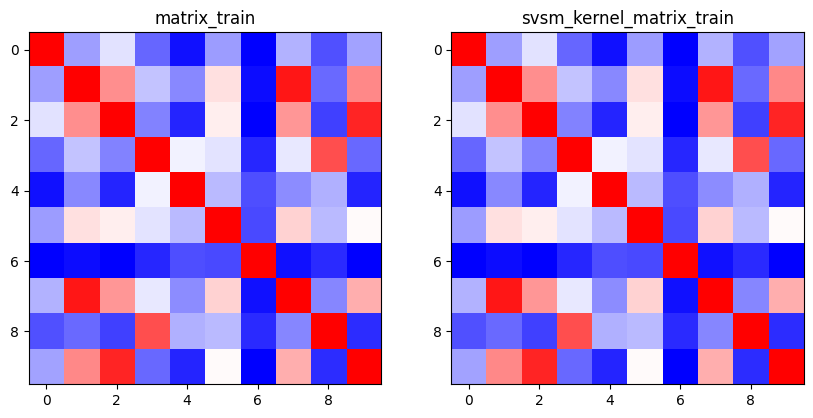

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("matrix_train")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title("svsm_kernel_matrix_train")
plt.show()

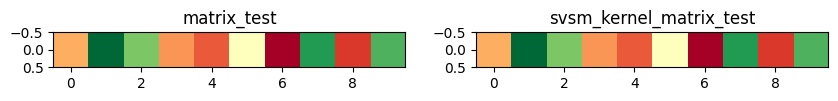

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[0].set_title("matrix_test")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[1].set_title("svsm_kernel_matrix_test")
plt.show()

In [35]:
svc = SVC(kernel="precomputed")
svc.fit(svsm_kernel_matrix_train,Y_train[:nb1])
result1 = svc.score(svsm_kernel_matrix_train,Y_train[:nb1])
result2 = svc.score(svsm_kernel_matrix_test,Y_val[:nb2])
print(result1, result2)

0.9 0.0


---

## tensornetwork simulation

In [67]:
def get_exp(x_t, n_dim, kernel):
    circuit = kernel.construct_circuit(x_t[0],x_t[0],measurement=False)
    converter = CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, _ = converter.amplitude(a)  
    return exp
def get_operand(circuit,n_dim):
    a = str(0).zfill(n_dim)
    converter = CircuitToEinsum(circuit, backend='numpy')
    _, oper = converter.amplitude(a)  
    return oper    
def all_operands_parallel(circuit, n_dim, num_cpu):
    with Pool(processes=num_cpu, maxtasksperchild=100) as pool:
        indices_list = list(range(len(circuit)))
        operands = pool.starmap(get_operand, [(circuit[i],n_dim) for i in indices_list])
    return operands
def kernel_matrix_tnsm(y_t, x_t, exp, opers, indices_list, options, mode=None):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i, oper = -1, opers[0]
    with Network(exp, *oper, options=options) as tn:
        tn.contract_path()
        for i1, i2 in indices_list:
            i += 1
            tn.reset_operands(*opers[i])     
            amp_tn = abs(tn.contract()) ** 2
            kernel_matrix[i1-1][i2-1] = np.round(amp_tn,8) 
        tn.free()
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix

In [80]:
n_dim = 10
data_train, data_val  = data_prepare(n_dim, X_train, X_val)

In [81]:
bsp_qc = make_bsp(n_dim)
bsp_kernel_tnsm = QuantumKernel(feature_map=bsp_qc)

In [82]:
indices_list_t = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_v = list(product(range(1, len(data_val) + 1),range(1, len(data_train) + 1)))
len(indices_list_t),len(indices_list_v)

(45, 10)

In [83]:
circuit_train = all_circuits_parallel(data_train, data_train, indices_list_t, n_dim, bsp_kernel_tnsm, 10)
circuit_val   = all_circuits_parallel(data_val, data_train, indices_list_v, n_dim, bsp_kernel_tnsm, 10)
len(circuit_train),len(circuit_val)

(45, 10)

In [84]:
exp = get_exp(data_train, n_dim, bsp_kernel_tnsm)
len(exp)


371

In [85]:
oper_train = all_operands_parallel(circuit_train, n_dim, 10)
oper_val   = all_operands_parallel(circuit_val,n_dim,10)
len(oper_train),len(oper_val)

(45, 10)

In [107]:
print(oper_train[1][80])


[[ 0.9733117 +0.j -0.22948712+0.j]
 [ 0.22948712+0.j  0.9733117 +0.j]]


In [110]:
print(oper_train[0][80]-oper_train[1][80])


[[-0.03406136+0.j -0.11374576+0.j]
 [ 0.11374576+0.j -0.03406136+0.j]]


In [74]:
#oper = oper_train[0]
options = NetworkOptions(blocking="auto")
#network = Network(exp, *oper,options=options)
#path, info = network.contract_path()

In [75]:
tnsm_kernel_matrix_train = kernel_matrix_tnsm(data_train, data_train, exp, oper_train, indices_list_t, options, mode='train')
tnsm_kernel_matrix_test  = kernel_matrix_tnsm(data_val, data_train, exp, oper_val, indices_list_v, options, mode=None)

In [76]:
tnsm_kernel_matrix_train.shape

(10, 10)

In [77]:
(tnsm_kernel_matrix_train-svsm_kernel_matrix_train).max()

0.010749300000000017

In [78]:
(tnsm_kernel_matrix_test-svsm_kernel_matrix_test).max()

0.0021075299999999686

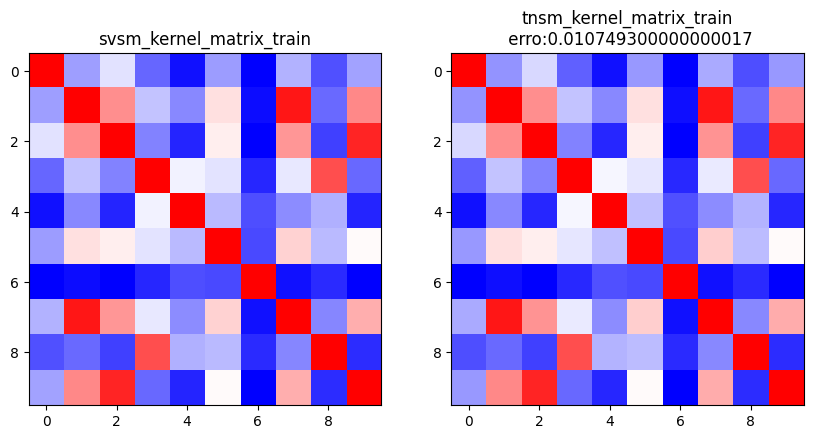

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("svsm_kernel_matrix_train")
axs[1].imshow(np.asmatrix(tnsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title(f"tnsm_kernel_matrix_train\n erro:{(tnsm_kernel_matrix_train-svsm_kernel_matrix_train).max()}")
plt.show()